# Libraries Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from PIL import ImageFont

import joblib
from geexhp import datasetup as dset

from tensorflow.keras.utils import plot_model # type: ignore
import visualkeras
from geexhp import datavis
datavis.configure_matplotlib()

from geexhp import cnn

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Data Setup

In [2]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [2]:
df = pd.read_parquet("../data/__data.parquet")

In [3]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [4]:
abundance_features = ["C2H6","CH4","CO","CO2","H2","H2O","HCN","N2","N2O","NH3","O2","O3","PH3"]
planetary_features = ["ATMOSPHERE-PRESSURE","ATMOSPHERE-TEMPERATURE", "OBJECT-DIAMETER", "OBJECT-GRAVITY"]

abundance_units = len(abundance_features)
planetary_units = len(planetary_features)

y_abundance = dfabun[abundance_features].values
y_planetary = dfabun[planetary_features].values

albedo = np.array([np.array(d) for d in dfabun['ALBEDO'].to_numpy()])

In [5]:
X_train, X_test, y_abundance_train, y_abundance_test, y_planetary_train, y_planetary_test = train_test_split(
    albedo, y_abundance, y_planetary, test_size=0.2, random_state=42, stratify=dfabun["Earth_type"])

In [6]:
(X_train_scaled, X_test_scaled,
 y_abundance_train_scaled, y_abundance_test_scaled,
 y_planetary_train_scaled, y_planetary_test_scaled,
 x_scaler, y_scalers_abundance, y_scalers_planetary) = dset.normalize_data(
    X_train, X_test,
    y_abundance_train, y_abundance_test,
    y_planetary_train, y_planetary_test
)

Train input shape: (31800, 2304, 1)
Test input shape: (7951, 2304, 1)
Train abundance labels shape: (31800, 13)
Test abundance labels shape: (7951, 13)
Train planetary labels shape: (31800, 4)
Test planetary labels shape: (7951, 4)


In [7]:
joblib.dump(x_scaler, '../models/x_scaler.joblib')
joblib.dump(y_scalers_abundance, '../models/y_scalers_abundance.joblib')
joblib.dump(y_scalers_planetary, '../models/y_scalers_planetary.joblib')

['../models/y_scalers_planetary.joblib']

In [8]:
# Write the training data to TFRecords
dset.write_tfrecords('../data/train.tfrecords', X_train_scaled, y_abundance_train_scaled, y_planetary_train_scaled)

# Write the testing data to TFRecords
dset.write_tfrecords('../data/test.tfrecords', X_test_scaled, y_abundance_test_scaled, y_planetary_test_scaled)

Data successfully written to ../data/train.tfrecords
Data successfully written to ../data/test.tfrecords


In [9]:
feature_description = {
    'input_albedo': tf.io.FixedLenFeature([X_train_scaled.shape[1]], tf.float32),
    'abundance_labels': tf.io.FixedLenFeature([y_abundance_train_scaled.shape[1]], tf.float32),
    'planetary_labels': tf.io.FixedLenFeature([y_planetary_train_scaled.shape[1]], tf.float32),
}

In [10]:
def _parse_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    input_albedo = parsed_example['input_albedo']
    abundance_labels = parsed_example['abundance_labels']
    planetary_labels = parsed_example['planetary_labels']

    # Reshape input_albedo to match the expected input shape for Conv1D layers
    input_albedo = tf.reshape(input_albedo, [X_train_scaled.shape[1], 1])

    return input_albedo, {'abundance_output': abundance_labels, 'planetary_output': planetary_labels}

In [11]:
batch_size = 16

# Training dataset
train_dataset = tf.data.TFRecordDataset('../data/train.tfrecords')
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(buffer_size=1000)
#train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Testing dataset
test_dataset = tf.data.TFRecordDataset('../data/test.tfrecords')
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
subset_size = 2000
X_tune = X_train_scaled[:subset_size].reshape(subset_size, -1)
y_abundance_tune = y_abundance_train_scaled[:subset_size]
y_planetary_tune = y_planetary_train_scaled[:subset_size]

In [13]:
abundance_features = ["C2H6","CH4","CO","CO2","H2","H2O","HCN","N2","N2O","NH3","O2","O3","PH3"]
planetary_features = ["PRESSURE","TEMPERATURE", "DIAMETER", "GRAVITY"]

# Convolutional Neural Network 1D (CNN) with tuning hyperparameters

In [14]:
hypertuner = cnn.HyperTuningBayCNN(
    input_shape=(X_train_scaled.shape[1], 1),
    abundance_units=len(abundance_features),
    planetary_units=len(planetary_features)
)

search = hypertuner.search(X_tune, y_abundance_tune, y_planetary_tune, max_trials=70, search_epochs=5)

Reloading Tuner from hyperparam_search/cnn_bay_tuning/tuner0.json


In [17]:
train_dataset_size = sum(1 for _ in train_dataset)
validation_size = int(0.2 * train_dataset_size)
train_size = train_dataset_size - validation_size

validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

In [18]:
train_steps_per_epoch = (train_size + batch_size - 1) // batch_size
validation_steps = (validation_size + batch_size - 1) // batch_size

In [22]:
best_model, history = hypertuner.fit_best_model(
    train_dataset,
    validation_dataset,
    epochs=16,
    patience=5,
    train_steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/16
100/100 - 37s - 373ms/step - abundance_output_loss: 0.3291 - loss: 0.7087 - planetary_output_loss: 0.3796 - val_abundance_output_loss: 0.2211 - val_loss: 0.5179 - val_planetary_output_loss: 0.2968
Epoch 2/16
100/100 - 34s - 342ms/step - abundance_output_loss: 0.1938 - loss: 0.4707 - planetary_output_loss: 0.2769 - val_abundance_output_loss: 0.2085 - val_loss: 0.4718 - val_planetary_output_loss: 0.2633
Epoch 3/16
100/100 - 37s - 369ms/step - abundance_output_loss: 0.1663 - loss: 0.3683 - planetary_output_loss: 0.2020 - val_abundance_output_loss: 0.1188 - val_loss: 0.2714 - val_planetary_output_loss: 0.1526
Epoch 4/16
100/100 - 37s - 371ms/step - abundance_output_loss: 0.1533 - loss: 0.3285 - planetary_output_loss: 0.1752 - val_abundance_output_loss: 0.1140 - val_loss: 0.2758 - val_planetary_output_loss: 0.1618
Epoch 5/16
100/100 - 37s - 370ms/step - abundance_output_loss: 0.1325 - loss: 0.2741 - planetary_output_loss: 0.1417 - val_abundance_output_loss: 0.1161 - val_loss: 0.2

In [23]:
hypertuner.save("newmodel.keras")

Model saved at newmodel.keras


In [15]:
hypertuner.load_model("newmodel.keras")

Model loaded from newmodel.keras


In [16]:
hypertuner.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2304, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2300, 96)  │        576 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1150, 96)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_4        │ (None, 1150, 96)  │          0 │ max_pooling1d_2[… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1148, 256) │     73,984 │ mc_dropout_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 574, 256)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_5        │ (None, 574, 256)  │          0 │ max_pooling1d_3[… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 146944)    │          0 │ mc_dropout_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 192)       │ 28,213,440 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_6        │ (None, 192)       │          0 │ dense_2[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 448)       │     86,464 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_7        │ (None, 448)       │          0 │ dense_3[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abundance_output    │ (None, 13)        │      5,837 │ mc_dropout_7[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ planetary_output    │ (None, 4)         │      1,796 │ mc_dropout_7[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,146,292 (324.81 MB)

 Trainable params: 28,382,097 (108.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,764,195 (216.54 MB)

In [18]:
#hypertuner.plot_losses()

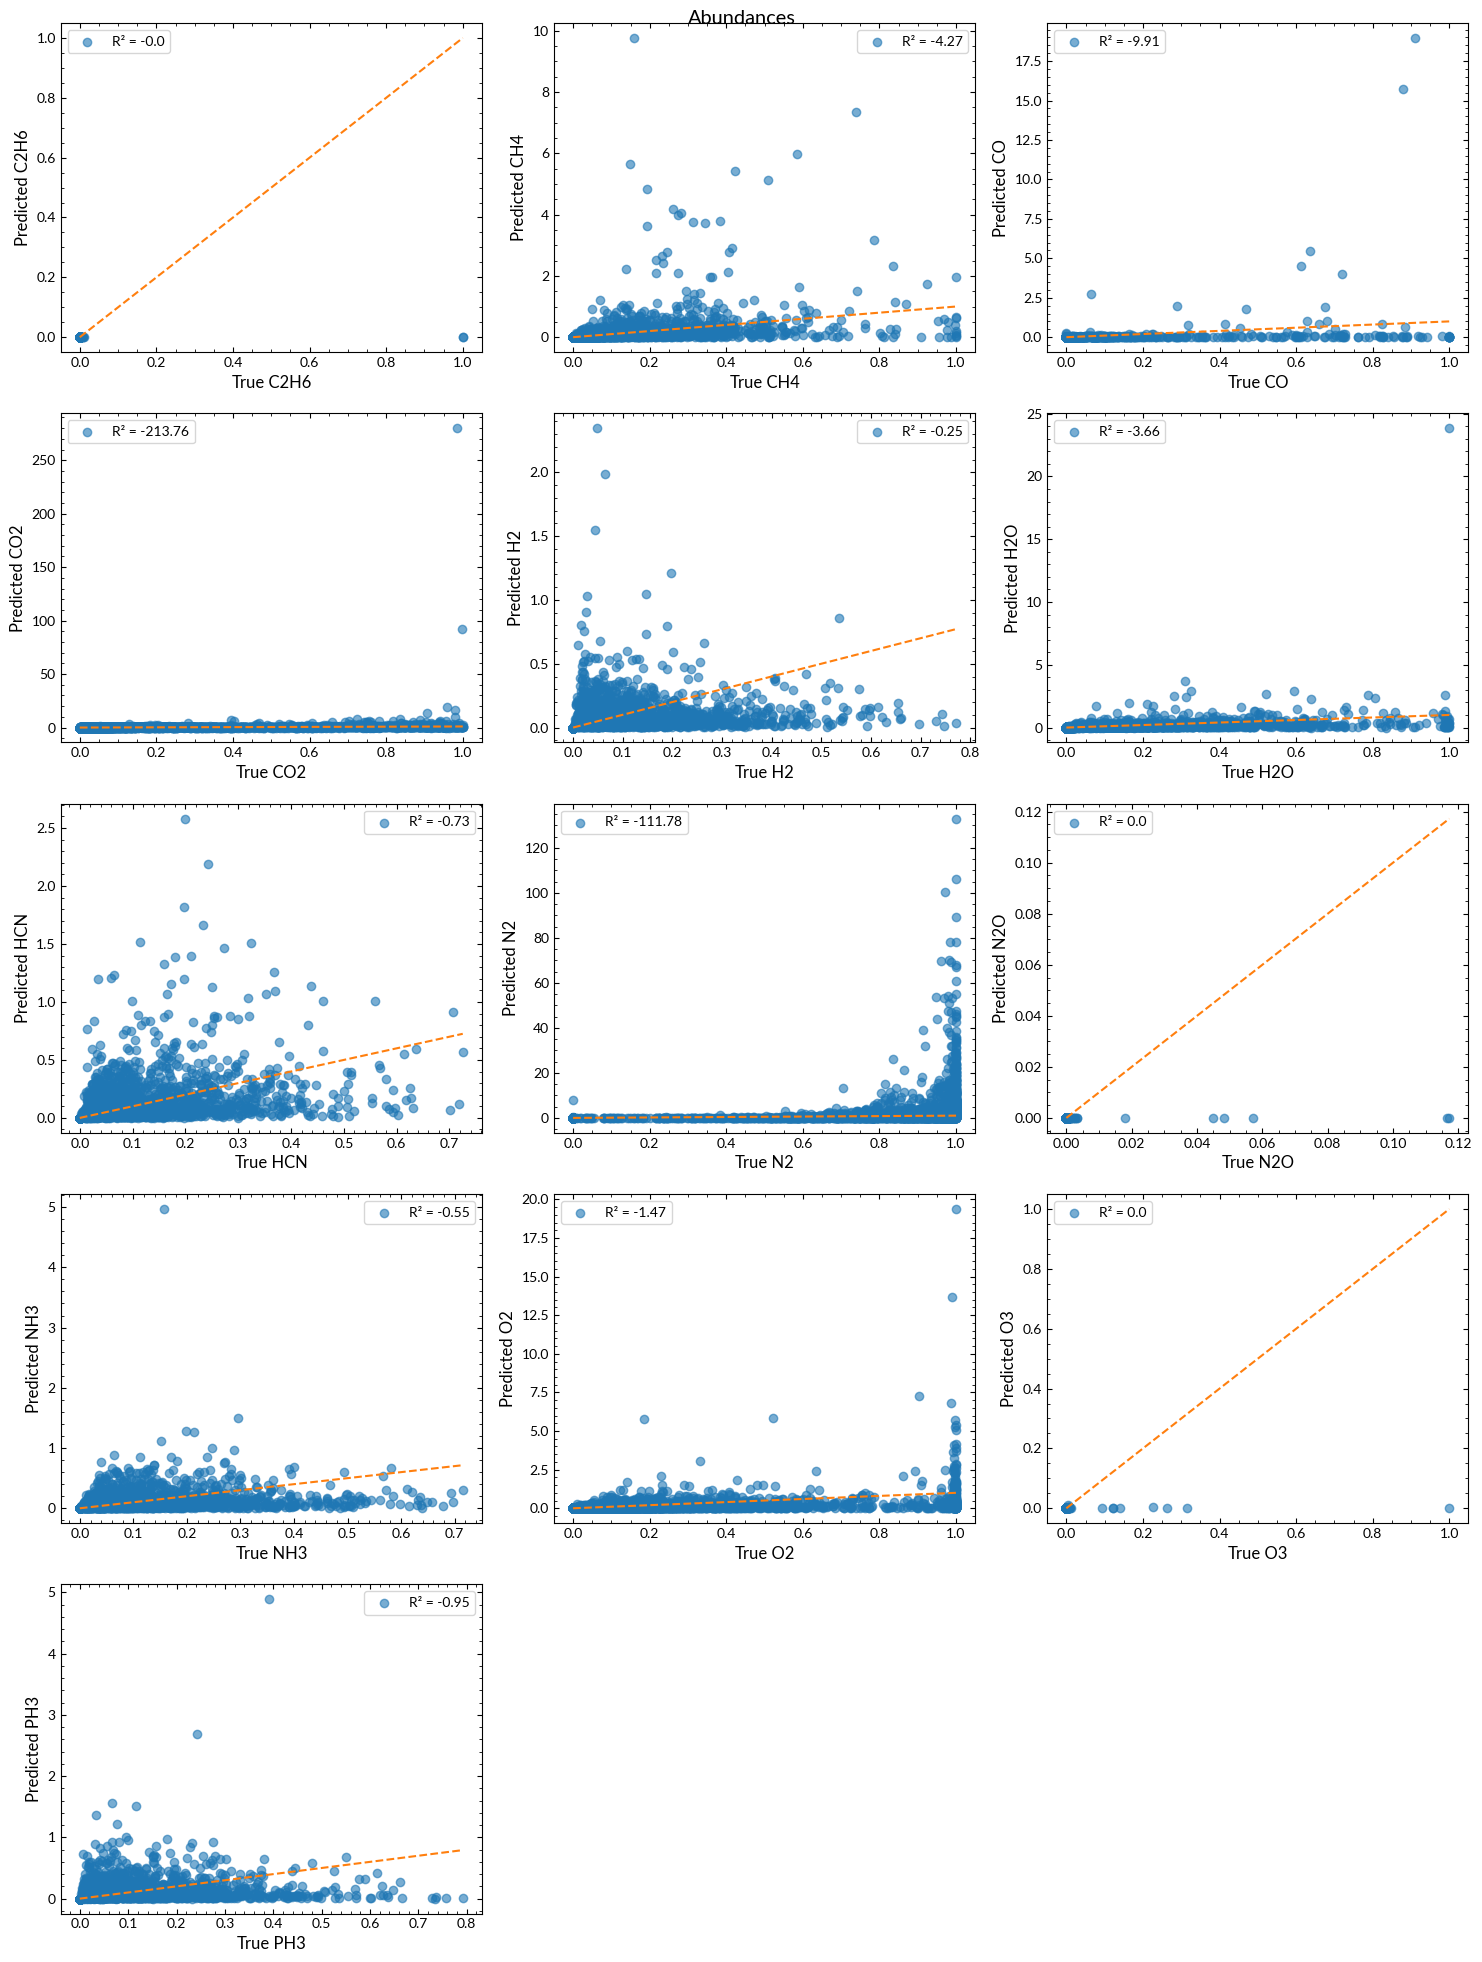

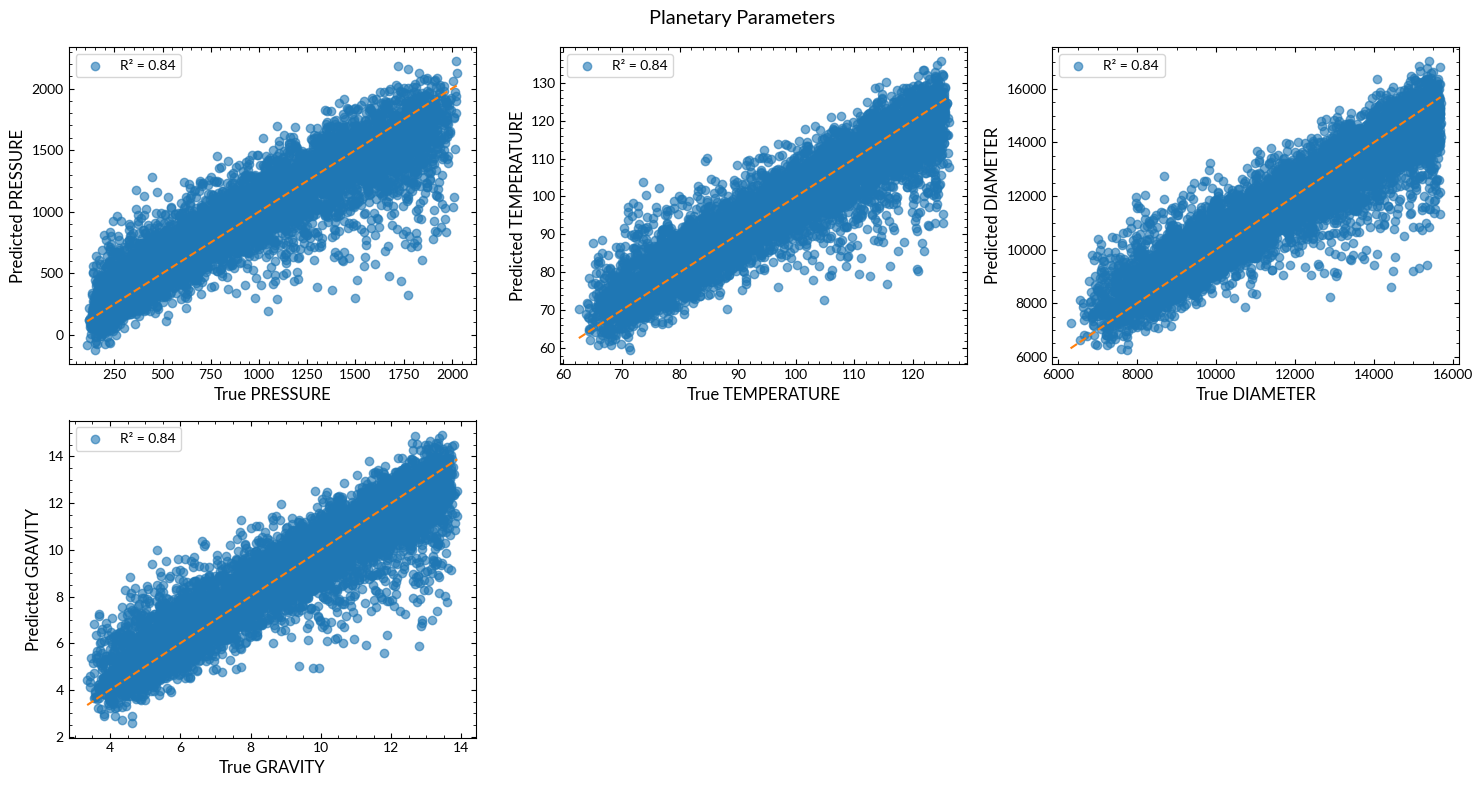

In [19]:
result = hypertuner.evaluate(test_dataset, abundance_features, planetary_features, y_scalers_abundance, y_scalers_planetary)

In [20]:
result["Abundances"]

,R² scores,MAE scores,RMSE scores
C2H6,-0.00,0.00,0.02
CH4,-4.27,0.05,0.25
CO,-9.91,0.02,0.29
CO2,-213.76,0.15,3.33
H2,-0.25,0.03,0.09
H2O,-3.66,0.04,0.29
HCN,-0.73,0.03,0.10
N2,-111.78,1.23,4.97
N2O,0.00,0.00,0.00
NH3,-0.55,0.03,0.10


In [21]:
result["Planetary Parameters"]

,R² scores,MAE scores,RMSE scores
PRESSURE,0.84,145.740005,203.960007
TEMPERATURE,0.84,4.660000,6.360000
DIAMETER,0.84,674.109985,921.320007
GRAVITY,0.84,0.780000,1.070000


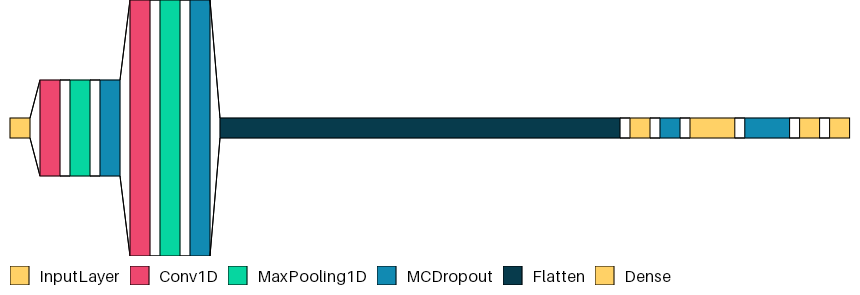

In [22]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(hypertuner.best_model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=False,
                        one_dim_orientation="z", scale_xy=1, font=font)

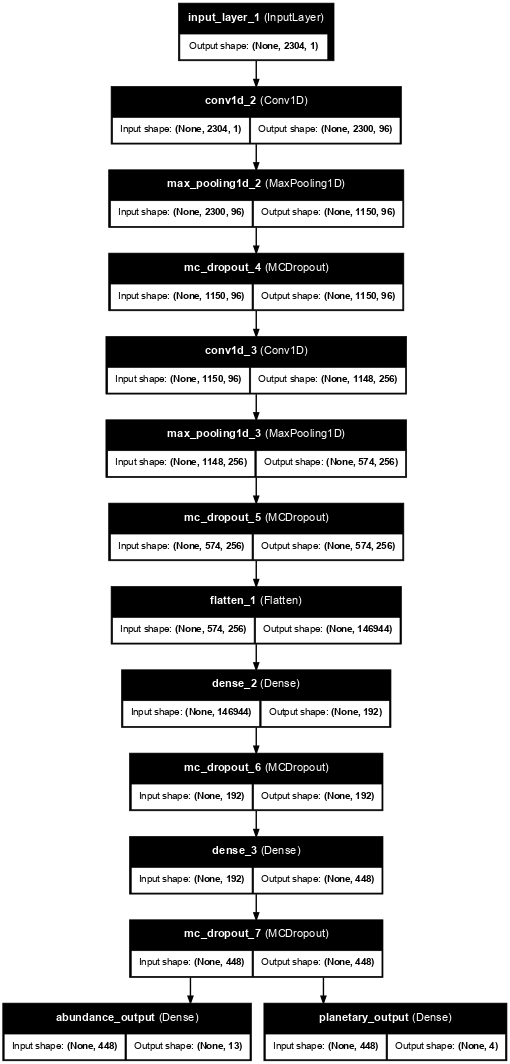

In [23]:
plot_model(hypertuner.best_model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', expand_nested=False, dpi=50)

In [24]:
# Select multiple samples
sample_indices = np.random.choice(len(X_test_scaled), size=100, replace=False)
X_samples = X_test_scaled[sample_indices]

# Generate predictions with uncertainty
n_iter = 100  # Number of Monte Carlo iterations
predictions = hypertuner.predict_with_uncertainty(X_samples, n_iter=n_iter)

predictions_inv = hypertuner.inverse_transform_predictions(
    predictions, y_scalers_abundance, y_scalers_planetary
)

In [26]:
samples_list = []
n_iter, n_samples, n_features = predictions_inv['abundance'].shape
samples = predictions_inv['abundance'].reshape(-1, n_features)
samples_list.append(samples)

# Labels for the samples
sample_labels = ['Model Predictions']

# True values for the selected samples (mean or specific sample)
y_true_abundance = np.mean(y_abundance_test[sample_indices], axis=0)

/home/sarah/Documentos/PSGCode/geexhp/core/datavis.py:235: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


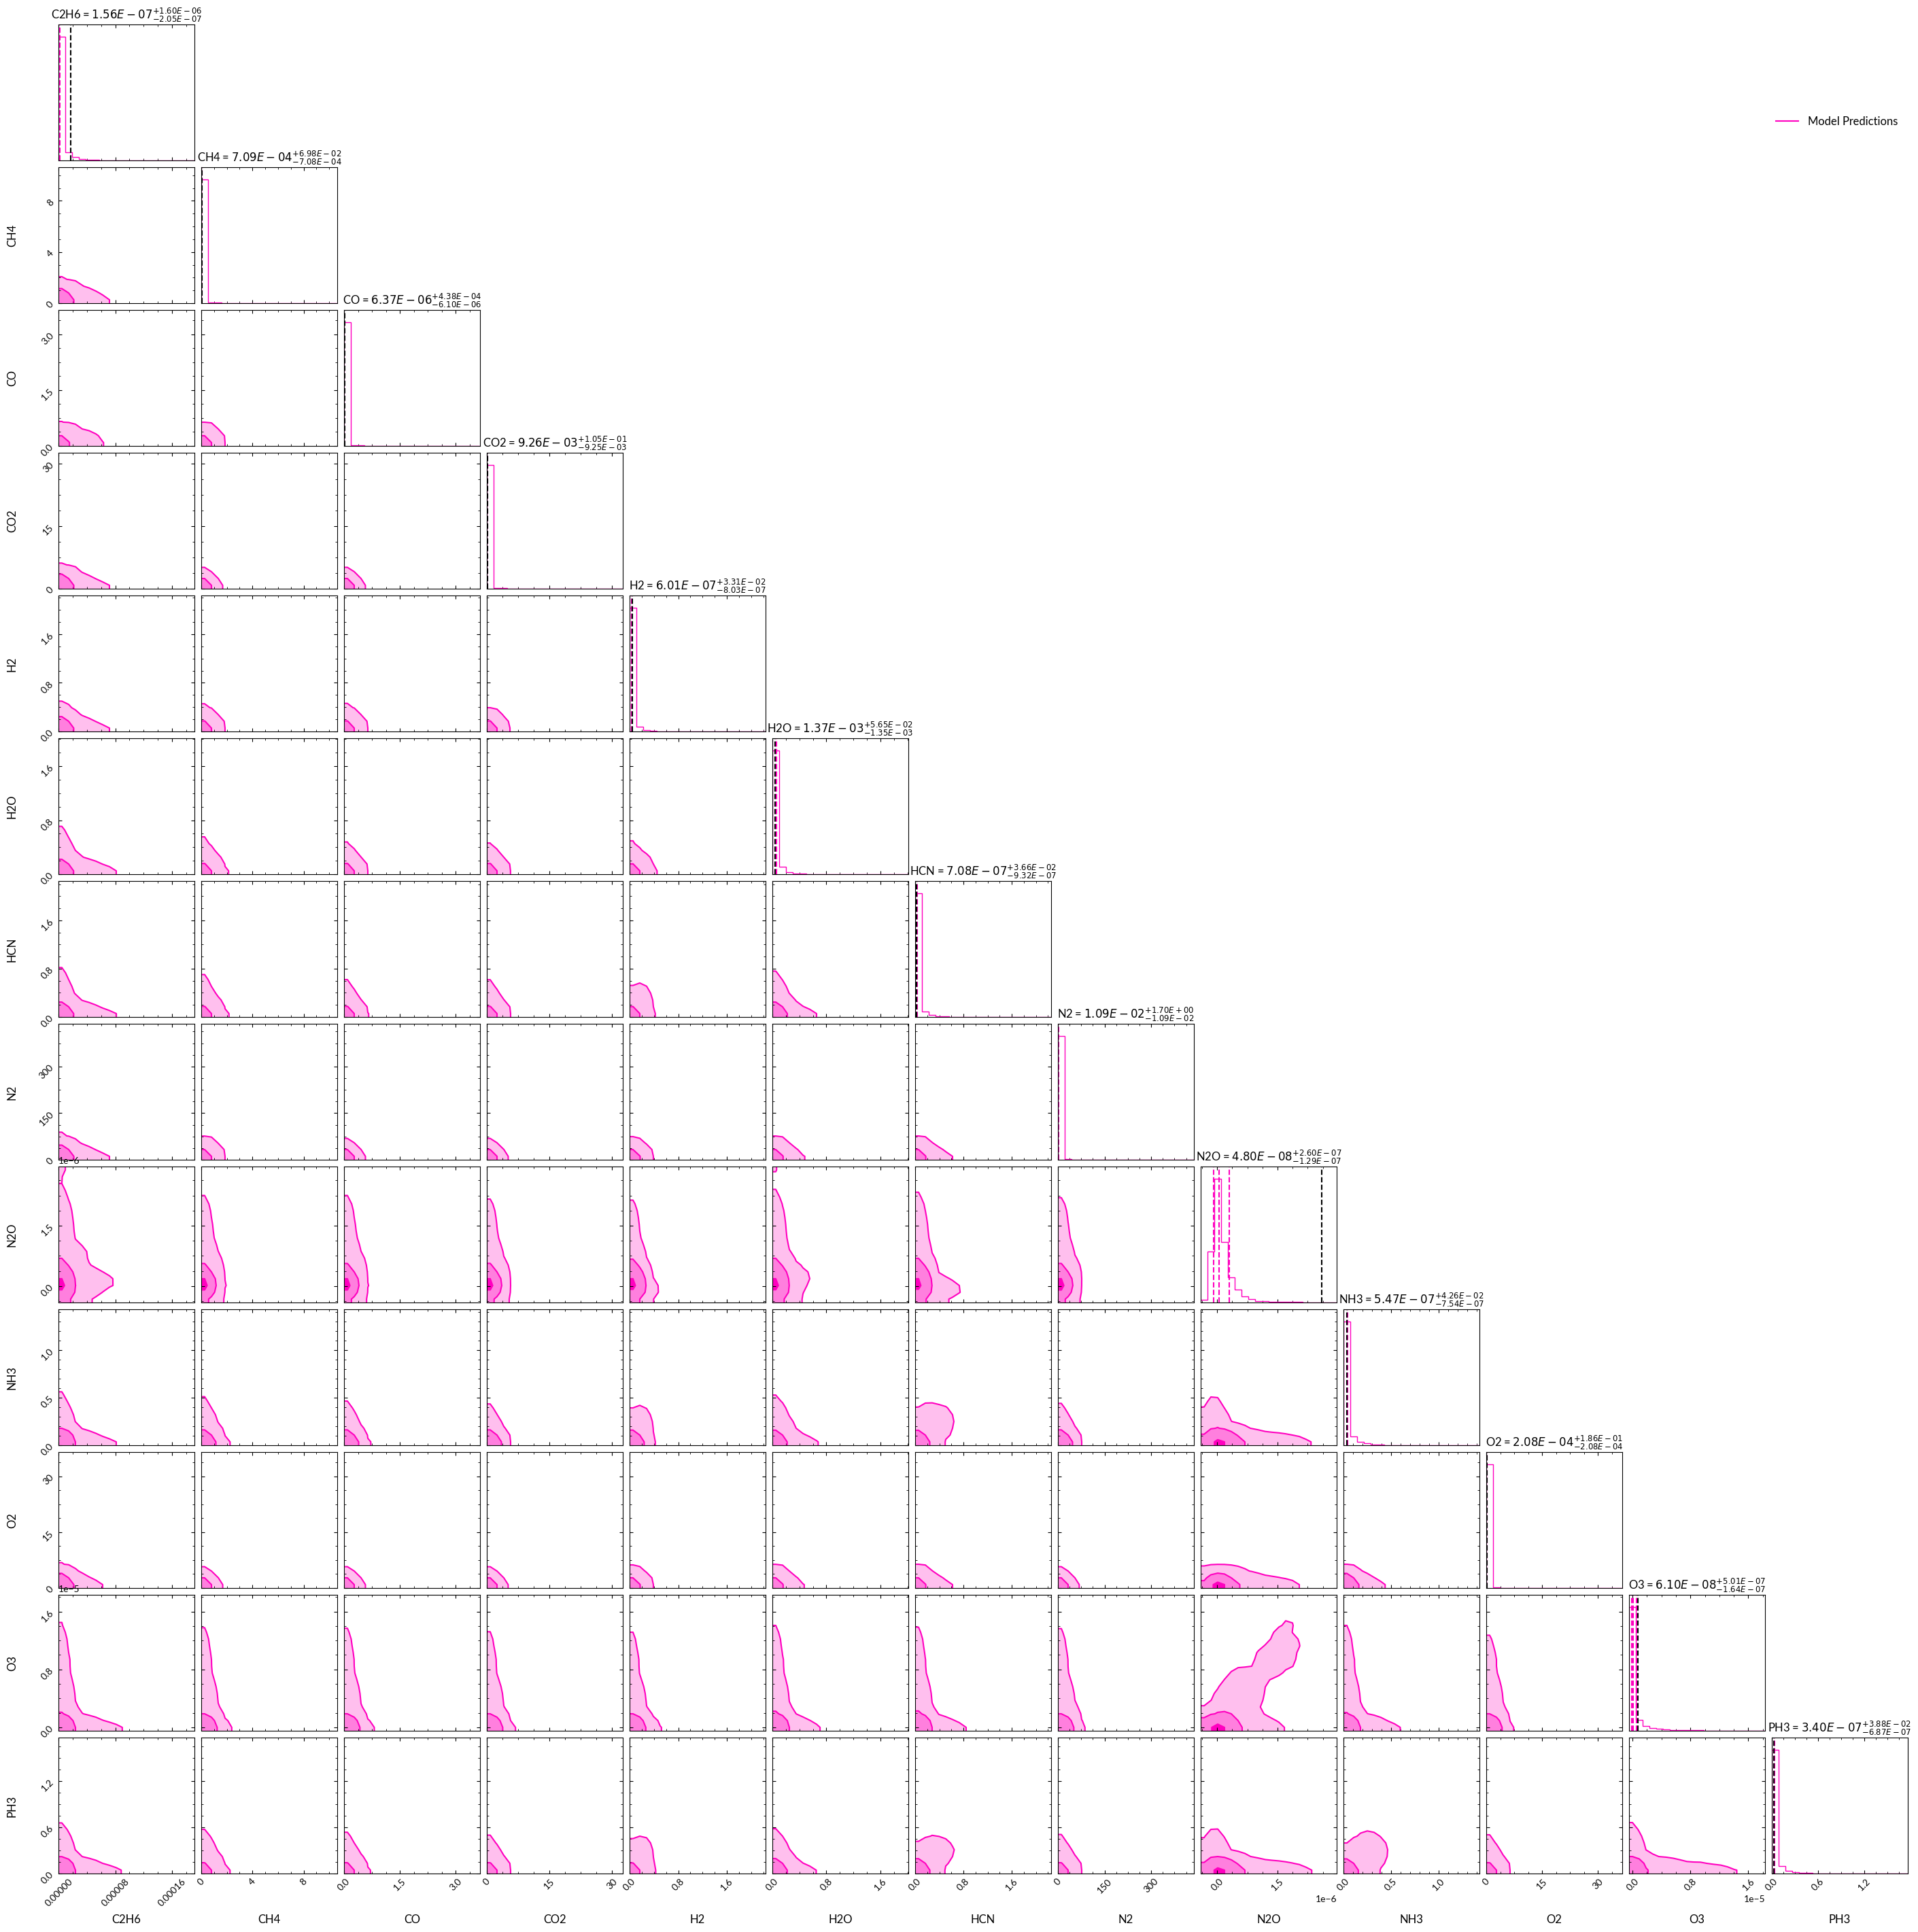

In [27]:
datavis.overlaid_corner(
    samples_list=samples_list,
    sample_labels=sample_labels,
    feature_names=abundance_features,
    true_values=y_true_abundance,
    filename='../images/corner_plot.png'
)